# Задание по программированию: Градиентный бустинг своими руками

*__Внимание__: в тексте задания произошли изменения - поменялось число деревьев (теперь 50), правило изменения величины шага в задании 3 и добавился параметр `random_state` у решающего дерева. Правильные ответы не поменялись, но теперь их проще получить. Также исправлена опечатка в функции `gbm_predict`.*


В этом задании будет использоваться датасет boston из sklearn.datasets. Оставьте __последние 25% объектов__ для контроля качества, разделив `X` и `y` на `X_train`, `y_train` и `X_test`, `y_test`.

Целью задания будет реализовать простой вариант градиентного бустинга над регрессионными деревьями для случая квадратичной функции потерь.

In [1]:
from sklearn import datasets, tree, ensemble
from sklearn.cross_validation import train_test_split
from sklearn.metrics          import mean_squared_error

import numpy as np

C:\Users\Insassin\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### The Boston Housing Dataset
__Dataset Naming__
```
The name for this dataset is simply boston. It has two prototasks: nox, in which the nitrous oxide level is to be predicted; and price, in which the median value of a home is to be predicted
```
__Miscellaneous Details__

__-Origin__
 The origin of the boston housing data is Natural. 
__-Usage__
 This dataset may be used for Assessment. 
__-Number of Cases__
 The dataset contains a total of 506 cases. 
__-Order__
 The order of the cases is mysterious. 
__-Variables__
 There are 14 attributes in each case of the dataset. They are:
```
CRIM - per capita crime rate by town
ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS - proportion of non-retail business acres per town.
CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
NOX - nitric oxides concentration (parts per 10 million)
RM - average number of rooms per dwelling
AGE - proportion of owner-occupied units built prior to 1940
DIS - weighted distances to five Boston employment centres
RAD - index of accessibility to radial highways
TAX - full-value property-tax rate per $10,000
PTRATIO - pupil-teacher ratio by town
B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
LSTAT - % lower status of the population
MEDV - Median value of owner-occupied homes in $1000's
```
__-Note__
```
Variable #14 seems to be censored at 50.00 (corresponding to a median price of $50,000); Censoring is suggested by the fact that the highest median price of exactly $50,000 is reported in 16 cases, while 15 cases have prices between $40,000 and $50,000, with prices rounded to the nearest hundred. Harrison and Rubinfeld do not mention any censoring.
```

In [2]:
boston = datasets.load_boston()
X, y = boston.data, boston.target

X_train = X[:X.shape[0]*0.75,:]
X_test = X[X.shape[0]*0.75:,:]
y_train = y[:X.shape[0]*0.75]
y_test = y[X.shape[0]*0.75:]

C:\Users\Insassin\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Insassin\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Insassin\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Insassin\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [3]:
def write_answer(answer, file_name):
    with open(file_name, "w") as file_out:
        file_out.write(str(answer))

__Задание 1__

Как вы уже знаете из лекций, бустинг - это метод построения композиций базовых алгоритмов с помощью последовательного добавления к текущей композиции нового алгоритма с некоторым коэффициентом. Градиентный бустинг обучает каждый новый алгоритм так, чтобы он приближал антиградиент ошибки по ответам композиции на обучающей выборке. Аналогично минимизации функций методом градиентного спуска, в градиентном бустинге мы подправляем композицию, изменяя алгоритм в направлении антиградиента ошибки. Воспользуйтесь формулой из лекций, задающей ответы на обучающей выборке, на которые нужно обучать новый алгоритм (фактически это лишь чуть более подробно расписанный градиент от ошибки), и получите частный ее случай, если функция потерь `L` - квадрат отклонения ответа композиции `a(x)` от правильного ответа `y` на данном `x`.

Если вы давно не считали производную самостоятельно, вам поможет таблица производных элементарных функций (которую несложно найти в интернете) и правило дифференцирования сложной функции. После дифференцирования квадрата у вас возникнет множитель 2 — т.к. нам все равно предстоит выбирать коэффициент, с которым будет добавлен новый базовый алгоритм, проигноируйте этот множитель при дальнейшем построении алгоритма.

In [5]:
# y - правильный ответ, z - полученный ответ
def L(y, z):
    return z - y

__Задание 2__

Заведите массив для объектов `DecisionTreeRegressor` (будем их использовать в качестве базовых алгоритмов) и для вещественных чисел (это будут коэффициенты перед базовыми алгоритмами). В цикле обучите последовательно 50 решающих деревьев с параметрами `max_depth=5` и `random_state=42` (остальные параметры - по умолчанию). В бустинге зачастую используются сотни и тысячи деревьев, но мы ограничимся 50, чтобы алгоритм работал быстрее, и его было проще отлаживать (т.к. цель задания разобраться, как работает метод). Каждое дерево должно обучаться на одном и том же множестве объектов, но ответы, которые учится прогнозировать дерево, будут меняться в соответствие с полученным в задании 1 правилом. Попробуйте для начала всегда брать коэффициент равным 0.9. Обычно оправдано выбирать коэффициент значительно меньшим - порядка 0.05 или 0.1, но т.к. в нашем учебном примере на стандартном датасете будет всего 50 деревьев, возьмем для начала шаг побольше.

В процессе реализации обучения вам потребуется функция, которая будет вычислять прогноз построенной на данный момент композиции деревьев на выборке `X`:

```
def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in 
      zip(base_algorithms_list, coefficients_list)]) for x in X]
```      
(считаем, что base_algorithms_list - список с базовыми алгоритмами, coefficients_list - список с коэффициентами перед алгоритмами)

Эта же функция поможет вам получить прогноз на контрольной выборке и оценить качество работы вашего алгоритма с помощью `mean_squared_error` в `sklearn.metrics`. Возведите результат в степень 0.5, чтобы получить RMSE. Полученное значение RMSE — ответ в пункте 2.

In [6]:
def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in 
                  zip(base_algorithms_list, coefficients_list)]) for x in X]

base_algorithms_list = list() # для объектов DecisionTreeRegressor
coefficients_list = list()    # для скоэффициентов перед алгоритмами
y_cur = np.array(y_train)
for i in range(50):
    regressor = tree.DecisionTreeRegressor(max_depth=5, random_state=42).fit(X_train, y_cur)
    base_algorithms_list.append(regressor)
    coefficients_list.append(0.9)
    
    y_cur = L(gbm_predict(X_train), y_train)
    
#print gbm_predict(X_test)
error = np.sqrt(mean_squared_error(y_test, gbm_predict(X_test)))
write_answer(error, 'ans_1.txt')
print error

5.47665097417


__Задание 3__

Вас может также беспокоить, что при движении с постоянным шагом вблизи минимума ошибки ответы на обучающей выборке меняются слишком резко, перескакивая через минимум. Попробуйте уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле 0.9 / (1.0 + i), где i - номер итерации (от 0 до 49). Используйте качество работы алгоритма как __ответ в пункте 3__. В реальности часто применяется следующая стратегия выбора шага: как только выбран алгоритм, подберем коэффициент перед ним численным методом оптимизации таким образом, чтобы отклонение от правильных ответов было минимальным. Мы не будем предлагать вам реализовать это для выполнения задания, но рекомендуем попробовать разобраться с такой стратегией и реализовать ее при случае для себя.

In [7]:
base_algorithms_list = list()
coefficients_list = list()
y_cur = np.array(y_train)
for i in range(50):
    regressor = tree.DecisionTreeRegressor(max_depth=5, random_state=42).fit(X_train, y_cur)
    base_algorithms_list.append(regressor)
    coefficients_list.append(0.9 / (1. + i))
    
    y_cur = L(gbm_predict(X_train), y_train)

error = np.sqrt(mean_squared_error(y_test, gbm_predict(X_test)))
write_answer(error, 'ans_2.txt')
print error

4.81089328026


__Задание 4__

Реализованный вами метод - градиентный бустинг над деревьями - очень популярен в машинном обучении. Он представлен как в самой библиотеке `sklearn`, так и в сторонней библиотеке `XGBoost`, которая имеет свой питоновский интерфейс. На практике XGBoost работает заметно лучше `GradientBoostingRegressor` из `sklearn`, но для этого задания вы можете использовать любую реализацию. Исследуйте, переобучается ли градиентный бустинг с ростом числа итераций (и подумайте, почему), а также с ростом глубины деревьев. На основе наблюдений выпишите через пробел номера правильных из приведенных ниже утверждений в порядке возрастания номера (это будет __ответ в п.4__):

    1) С увеличением числа деревьев, начиная с некоторого момента, качество работы градиентного бустинга не меняется существенно.

    2) С увеличением числа деревьев, начиная с некоторого момента, градиентный бустинг начинает переобучаться.

    3) С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга на тестовой выборке начинает ухудшаться

    4) С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга перестает существенно изменяться

In [8]:
from sklearn.ensemble import GradientBoostingRegressor
%pylab inline

Populating the interactive namespace from numpy and matplotlib


[8.8140385834775916, 7.4519049493353506, 6.7522891557278406]
[8.2617228931868549, 6.680039215523534, 5.8192098489459578]
[8.436391618751891, 6.9423814364068095, 6.142216262313819]
[8.7010135212469564, 7.3800253676538983, 6.6712927520260115]
[8.6172341033509774, 7.1007828828259365, 6.4111697182257625]
[8.6821913040119956, 7.3510296785250313, 6.6243348847655978]


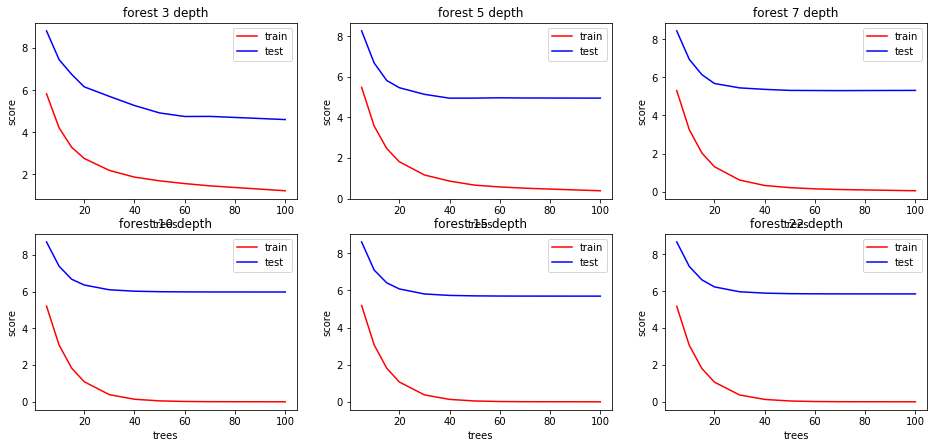

In [9]:
trees = np.array([5, 10, 15, 20, 30, 40, 50, 60, 70, 100])
depths = np.array([3, 5, 7, 10, 15, 22])
pyplot.figure(figsize=(16, 11))
i = 1
for d in depths:
    scores_train = []
    scores_test = []
    for num in trees:
        boost = GradientBoostingRegressor(n_estimators=num, max_depth=d, random_state=42).fit(X_train, y_train)
        scores_train.append(np.sqrt(mean_squared_error(y_train, boost.predict(X_train))))
        scores_test.append(np.sqrt(mean_squared_error(y_test, boost.predict(X_test))))
    print(scores_test[:3])
    ax = plt.subplot(3, 3, i)
    ax.set_title("forest {} depth".format(d))
    pyplot.plot(trees, scores_train, color="red", label="train")
    pyplot.plot(trees, scores_test, color="blue", label="test")
    pyplot.xlabel("trees")
    pyplot.ylabel("score")
    pyplot.legend()
    i += 1

In [10]:
answer_4 = '2 3'
write_answer(answer_4, 'ans_3.txt')

__Задание 5__

Сравните получаемое с помощью градиентного бустинга качество с качеством работы линейной регрессии. Для этого обучите `LinearRegression` из `sklearn.linear_model` (с параметрами по умолчанию) на обучающей выборке и оцените для прогнозов полученного алгоритма на тестовой выборке `RMSE`. Полученное качество - __ответ в пункте 5__. В данном примере качество работы простой модели должно было оказаться хуже, но не стоит забывать, что так бывает не всегда. В заданиях к этому курсу вы еще встретите пример обратной ситуации.

In [11]:
from sklearn.linear_model import LinearRegression

regr = LinearRegression().fit(X_train, y_train)
pred = regr.predict(X_test)
error = np.sqrt(mean_squared_error(y_test, pred))
write_answer(error, 'ans_4.txt')
print error

8.27046803494
